---

### Import Libraries and Dependencies

In [21]:
# Import libraries and dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import yfinance as yf

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [22]:
#Download stock data
def download_data(tickers, start_date):
    stock_data = yf.download(tickers,start=start_date)
    stock_data = stock_data.drop(columns=["Adj Close", "High", "Low", "Open", "Volume"])
    stock_data["Close"] = stock_data['Close'].astype(float)
    stock_data = stock_data.dropna()
    return stock_data

In [23]:
# # Download SPY (SP500) Prices
# SP500_df = download_data(["SPY"], "1980-01-01")
# SP500_df.head()

## Save data as a CSV file

In [24]:
# csv_path = Path("Data/SP500.csv")
# SP500_df .to_csv(csv_path)

## Read in CSV as Pandas DataFrame

In [43]:
# Set path to CSV and read in CSV
csv_path = Path('Data/SP500.csv')
SP500_df=pd.read_csv(csv_path).set_index("Date")
SP500_df

,Close
Date,
1993-01-29,43.937500
1993-02-01,44.250000
1993-02-02,44.343750
1993-02-03,44.812500
1993-02-04,45.000000
...,...
2020-09-18,330.649994
2020-09-21,326.970001
2020-09-22,330.299988


## Calculate Daily Returns

In [44]:
# Calculate daily percent return
SP500_df['daily_return'] = SP500_df['Close'].pct_change()
SP500_df

,Close,daily_return
Date,,
1993-01-29,43.937500,NaN
1993-02-01,44.250000,0.007112
1993-02-02,44.343750,0.002119
1993-02-03,44.812500,0.010571
1993-02-04,45.000000,0.004184
...,...,...
2020-09-18,330.649994,-0.015454
2020-09-21,326.970001,-0.011130
2020-09-22,330.299988,0.010184


## Construct Exponential Moving Average of Closing Prices (Trading Signal, Feature One)

In [45]:
# Set short and long windows
short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
SP500_df['fast_close'] = SP500_df['Close'].ewm(halflife=short_window).mean()
SP500_df['slow_close'] = SP500_df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
SP500_df['crossover_long'] = np.where(SP500_df['fast_close'] > SP500_df['slow_close'], 1.0, 0.0)
SP500_df['crossover_short'] = np.where(SP500_df['fast_close'] < SP500_df['slow_close'], -1.0, 0.0)
SP500_df['crossover_signal'] = SP500_df['crossover_long'] + SP500_df['crossover_short']

SP500_df.head()

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal
Date,,,,,,,
1993-01-29,43.93750,NaN,43.937500,43.937500,0.0,0.0,0.0
1993-02-01,44.25000,0.007112,44.145833,44.099163,1.0,0.0,1.0
1993-02-02,44.34375,0.002119,44.258929,44.186404,1.0,0.0,1.0
1993-02-03,44.81250,0.010571,44.554167,44.359558,1.0,0.0,1.0
1993-02-04,45.00000,0.004184,44.784274,44.505988,1.0,0.0,1.0


### Plot Exponential Moving Average of Closing Prices

<AxesSubplot:xlabel='Date'>

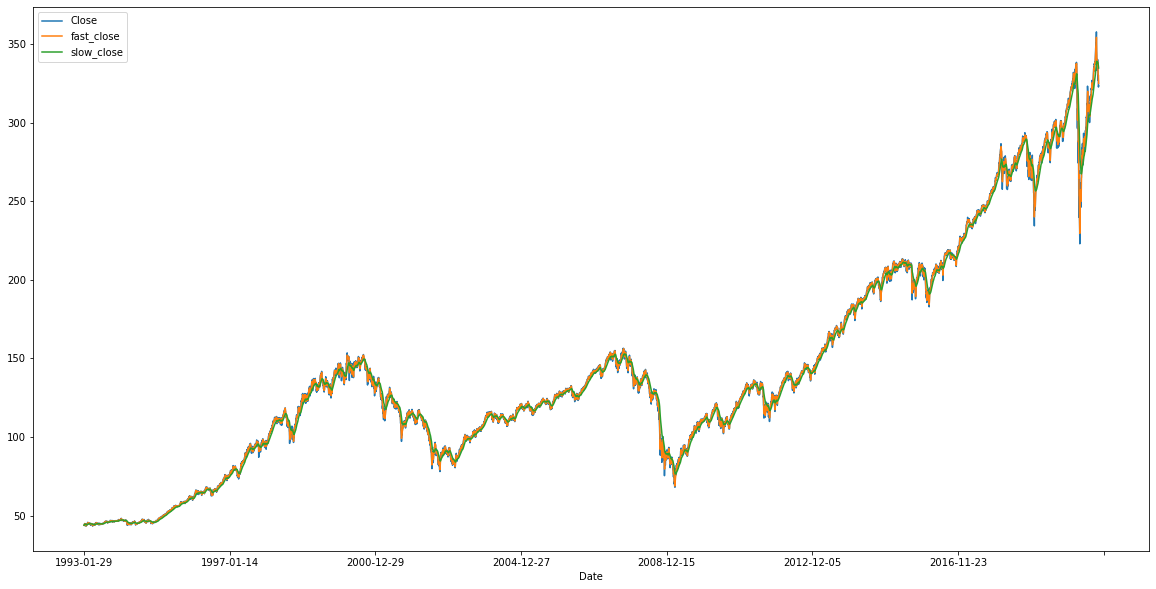

In [46]:
# Plot the EMA of BTC/USD closing prices
SP500_df[['Close', 'fast_close', 'slow_close']].plot(figsize=(20,10))

### Construct Exponential Moving Average of Daily Return Volatility (Trading Signal, Feature Two)

In [47]:
# Set short and long volatility windows
short_vol_window = 1
long_vol_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
SP500_df['fast_vol'] = SP500_df['daily_return'].ewm(halflife=short_vol_window).std()
SP500_df['slow_vol'] = SP500_df['daily_return'].ewm(halflife=long_vol_window).std()

# Construct a crossover trading signal
SP500_df['vol_trend_long'] = np.where(SP500_df['fast_vol'] < SP500_df['slow_vol'], 1.0, 0.0)
SP500_df['vol_trend_short'] = np.where(SP500_df['fast_vol'] > SP500_df['slow_vol'], -1.0, 0.0) 
SP500_df['vol_trend_signal'] = SP500_df['vol_trend_long'] + SP500_df['vol_trend_short']

SP500_df

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal
Date,,,,,,,,,,,,
1993-01-29,43.937500,NaN,43.937500,43.937500,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1993-02-01,44.250000,0.007112,44.145833,44.099163,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0
1993-02-02,44.343750,0.002119,44.258929,44.186404,1.0,0.0,1.0,0.003531,0.003531,0.0,0.0,0.0
1993-02-03,44.812500,0.010571,44.554167,44.359558,1.0,0.0,1.0,0.004889,0.004313,0.0,-1.0,-1.0
1993-02-04,45.000000,0.004184,44.784274,44.505988,1.0,0.0,1.0,0.003883,0.003693,0.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-18,330.649994,-0.015454,333.957464,337.631456,0.0,-1.0,-1.0,0.009278,0.012943,1.0,0.0,1.0
2020-09-21,326.970001,-0.011130,330.463733,336.917490,0.0,-1.0,-1.0,0.006609,0.012745,1.0,0.0,1.0
2020-09-22,330.299988,0.010184,330.381860,336.474336,0.0,-1.0,-1.0,0.013486,0.012698,0.0,-1.0,-1.0


### Plot Exponential Moving Average of Daily Return Volatility

<AxesSubplot:xlabel='Date'>

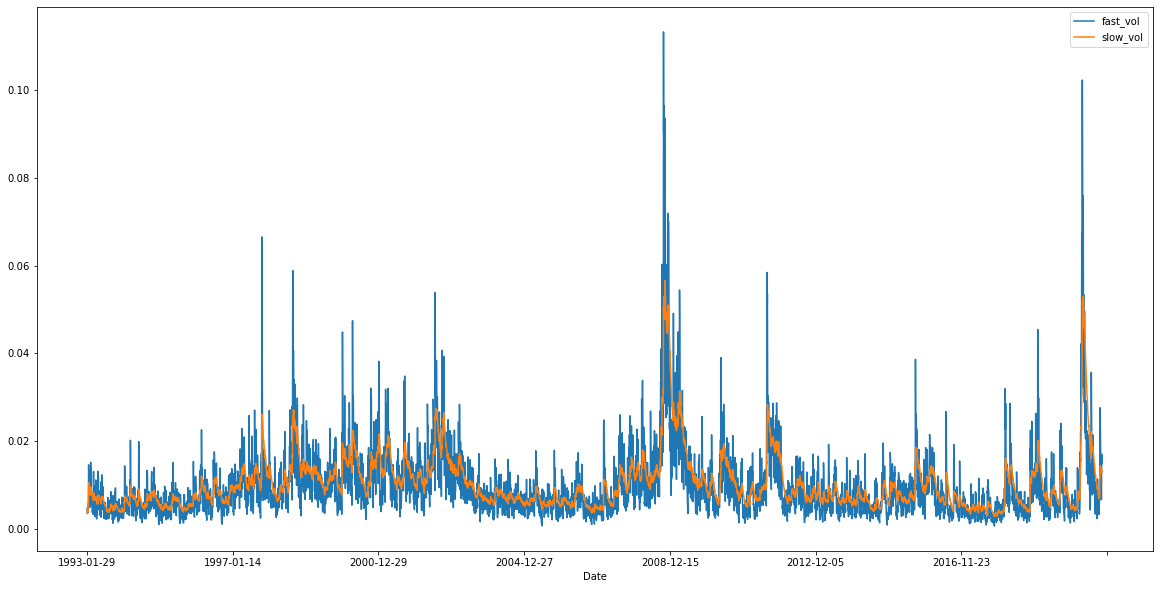

In [48]:
# Plot the EMA of BTC/USD daily return volatility
SP500_df[['fast_vol', 'slow_vol']].plot(figsize=(20,10))

### Construct Bollinger Band (Trading Signal, Feature Three)

In [49]:
# Set bollinger band window
bollinger_window = 20

# Calculate rolling mean and standard deviation
SP500_df['bollinger_mid_band'] = SP500_df['Close'].rolling(window=bollinger_window).mean()
SP500_df['bollinger_std'] = SP500_df['Close'].rolling(window=bollinger_window).std()
SP500_df
# Calculate upper and lowers bands of bollinger bandSP500_df
SP500_df['bollinger_upper_band']  = SP500_df['bollinger_mid_band'] + (SP500_df['bollinger_std'] * 1)
SP500_df['bollinger_lower_band']  = SP500_df['bollinger_mid_band'] - (SP500_df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
SP500_df['bollinger_long'] = np.where(SP500_df['Close'] < SP500_df['bollinger_lower_band'], 1.0, 0.0)
SP500_df['bollinger_short'] = np.where(SP500_df['Close'] > SP500_df['bollinger_upper_band'], -1.0, 0.0)
SP500_df['bollinger_signal'] = SP500_df['bollinger_long'] + SP500_df['bollinger_short']

SP500_df

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,
1993-01-29,43.937500,NaN,43.937500,43.937500,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-01,44.250000,0.007112,44.145833,44.099163,1.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-02,44.343750,0.002119,44.258929,44.186404,1.0,0.0,1.0,0.003531,0.003531,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-03,44.812500,0.010571,44.554167,44.359558,1.0,0.0,1.0,0.004889,0.004313,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-04,45.000000,0.004184,44.784274,44.505988,1.0,0.0,1.0,0.003883,0.003693,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-18,330.649994,-0.015454,333.957464,337.631456,0.0,-1.0,-1.0,0.009278,0.012943,1.0,0.0,1.0,342.273003,7.191878,349.464881,335.081125,1.0,0.0,1.0
2020-09-21,326.970001,-0.011130,330.463733,336.917490,0.0,-1.0,-1.0,0.006609,0.012745,1.0,0.0,1.0,341.647502,7.951481,349.598984,333.696021,1.0,0.0,1.0
2020-09-22,330.299988,0.010184,330.381860,336.474336,0.0,-1.0,-1.0,0.013486,0.012698,0.0,-1.0,-1.0,341.016501,8.336599,349.353099,332.679902,1.0,0.0,1.0


### Plot Bollinger Bands

<AxesSubplot:xlabel='Date'>

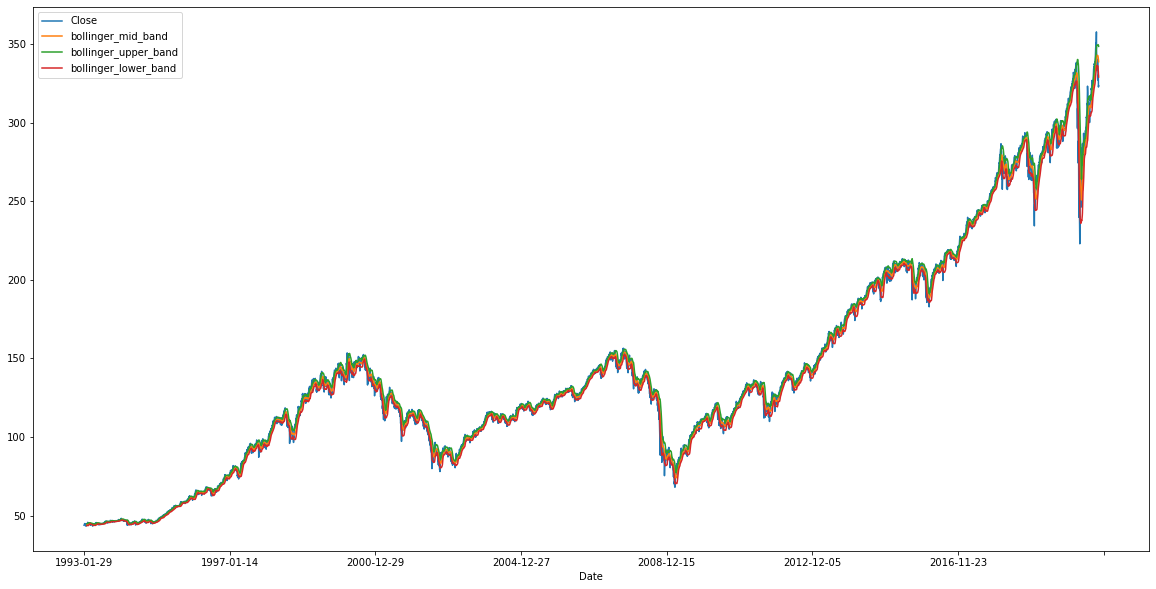

In [50]:
# Plot the Bollinger Bands for SP500 closing prices
SP500_df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

### Set X-Variable List and Filter to Obtain Associated Values

In [51]:
# Set x variable list of features
x_var_list = ['crossover_signal', 'vol_trend_signal', 'bollinger_signal']

# Filter by x-variable list
SP500_df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-09-18,-1.0,1.0,1.0
2020-09-21,-1.0,1.0,1.0
2020-09-22,-1.0,-1.0,1.0
2020-09-23,-1.0,-1.0,1.0
2020-09-24,-1.0,-1.0,1.0


### Shift the DataFrame Index by 1

In [52]:
# Shift DataFrame values by 1
SP500_df[x_var_list] = SP500_df[x_var_list].shift(1)
SP500_df[x_var_list].tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-09-18,-1.0,1.0,1.0
2020-09-21,-1.0,1.0,1.0
2020-09-22,-1.0,1.0,1.0
2020-09-23,-1.0,-1.0,1.0
2020-09-24,-1.0,-1.0,1.0


### Drop NAs and Replace Infs (Positive/Negative Infinity)

In [53]:
# Drop NAs and replace positive/negative infinity values
SP500_df.dropna(subset=x_var_list, inplace=True)
SP500_df.dropna(subset=['daily_return'], inplace=True)
SP500_df = SP500_df.replace([np.inf, -np.inf], np.nan)
SP500_df.head()

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal
Date,,,,,,,,,,,,,,,,,,,
1993-02-01,44.25000,0.007112,44.145833,44.099163,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-02,44.34375,0.002119,44.258929,44.186404,1.0,0.0,1.0,0.003531,0.003531,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-03,44.81250,0.010571,44.554167,44.359558,1.0,0.0,1.0,0.004889,0.004313,0.0,-1.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-04,45.00000,0.004184,44.784274,44.505988,1.0,0.0,1.0,0.003883,0.003693,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1993-02-05,44.96875,-0.000694,44.877976,44.597069,1.0,0.0,1.0,0.004837,0.004444,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0


### Construct the Dependent Variable

In [54]:
# Construct the dependent variable where if daily return is greater than 0, then 1, else, 0.
SP500_df['Positive Return'] = np.where(SP500_df['daily_return'] > 0, 1.0, 0.0)
SP500_df

,Close,daily_return,fast_close,slow_close,crossover_long,crossover_short,crossover_signal,fast_vol,slow_vol,vol_trend_long,vol_trend_short,vol_trend_signal,bollinger_mid_band,bollinger_std,bollinger_upper_band,bollinger_lower_band,bollinger_long,bollinger_short,bollinger_signal,Positive Return
Date,,,,,,,,,,,,,,,,,,,,
1993-02-01,44.250000,0.007112,44.145833,44.099163,1.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
1993-02-02,44.343750,0.002119,44.258929,44.186404,1.0,0.0,1.0,0.003531,0.003531,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
1993-02-03,44.812500,0.010571,44.554167,44.359558,1.0,0.0,1.0,0.004889,0.004313,0.0,-1.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
1993-02-04,45.000000,0.004184,44.784274,44.505988,1.0,0.0,1.0,0.003883,0.003693,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0
1993-02-05,44.968750,-0.000694,44.877976,44.597069,1.0,0.0,1.0,0.004837,0.004444,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-18,330.649994,-0.015454,333.957464,337.631456,0.0,-1.0,-1.0,0.009278,0.012943,1.0,0.0,1.0,342.273003,7.191878,349.464881,335.081125,1.0,0.0,1.0,0.0
2020-09-21,326.970001,-0.011130,330.463733,336.917490,0.0,-1.0,-1.0,0.006609,0.012745,1.0,0.0,1.0,341.647502,7.951481,349.598984,333.696021,1.0,0.0,1.0,0.0
2020-09-22,330.299988,0.010184,330.381860,336.474336,0.0,-1.0,-1.0,0.013486,0.012698,0.0,-1.0,1.0,341.016501,8.336599,349.353099,332.679902,1.0,0.0,1.0,1.0


### Assign Training and Testing Windows

In [55]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(SP500_df))
X_train = SP500_df[: split]
X_test = SP500_df[split:]
y_train = SP500_df['Positive Return'][: split]
y_test = SP500_df['Positive Return'][split:]

#X_train

In [56]:
#X_test

In [57]:
# Construct training start and end dates
training_start="1993-02-01"
training_end="2012-06-05"

# Construct testing start and end dates
testing_start="2012-06-06"
testing_end="2020-09-24"
    

### Separate X and Y Training Datasets

In [58]:
# Construct the x train and y train datasets
x_train = SP500_df[x_var_list][training_start:training_end]
y_train = SP500_df['Positive Return'][training_start:training_end]

x_train.tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2012-05-30,-1.0,-1.0,0.0
2012-05-31,-1.0,-1.0,0.0
2012-06-01,-1.0,-1.0,0.0
2012-06-04,-1.0,-1.0,1.0
2012-06-05,-1.0,-1.0,1.0



### Separate X and Y Testing Datasets

In [59]:
# Construct the x test and y test datasets
x_test = SP500_df[x_var_list][testing_start:testing_end]
y_test = SP500_df['Positive Return'][testing_start:testing_end]

x_test.tail()

,crossover_signal,vol_trend_signal,bollinger_signal
Date,,,
2020-09-18,-1.0,1.0,1.0
2020-09-21,-1.0,1.0,1.0
2020-09-22,-1.0,1.0,1.0
2020-09-23,-1.0,-1.0,1.0
2020-09-24,-1.0,-1.0,1.0


In [60]:
y_test.tail()

Date
2020-09-18    0.0
2020-09-21    0.0
2020-09-22    1.0
2020-09-23    0.0
2020-09-24    1.0
Name: Positive Return, dtype: float64

### Train Random Forest Model

In [61]:
# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
model.fit(x_train, y_train)

# Make a prediction of "y" values from the x test dataset
predictions = model.predict(x_test)

# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
results = y_test.to_frame()
#Results = Results.rename(columns="Actual Value", inplace=False)
results["Predicted Value"] = predictions
results

,Positive Return,Predicted Value
Date,,
2012-06-06,1.0,1.0
2012-06-07,1.0,1.0
2012-06-08,1.0,1.0
2012-06-11,0.0,1.0
2012-06-12,1.0,1.0
...,...,...
2020-09-18,0.0,1.0
2020-09-21,0.0,1.0
2020-09-22,1.0,1.0


In [62]:
# Add daily returns and rename columns
results["Return"] = SP500_df["daily_return"]

#Reorder column
results=results[["Return","Positive Return","Predicted Value"]]

#Rename column
# columns =["Return","Actual Value","Predicted Value"]
results.rename(columns={"Positive Return":"Actual Value"}, inplace=True)

results

,Return,Actual Value,Predicted Value
Date,,,
2012-06-06,0.022468,1.0,1.0
2012-06-07,0.000606,1.0,1.0
2012-06-08,0.007952,1.0,1.0
2012-06-11,-0.012697,0.0,1.0
2012-06-12,0.011491,1.0,1.0
...,...,...,...
2020-09-18,-0.015454,0.0,1.0
2020-09-21,-0.011130,0.0,1.0
2020-09-22,0.010184,1.0,1.0


### Plot Predicted Results vs. Actual Results

<AxesSubplot:xlabel='Date'>

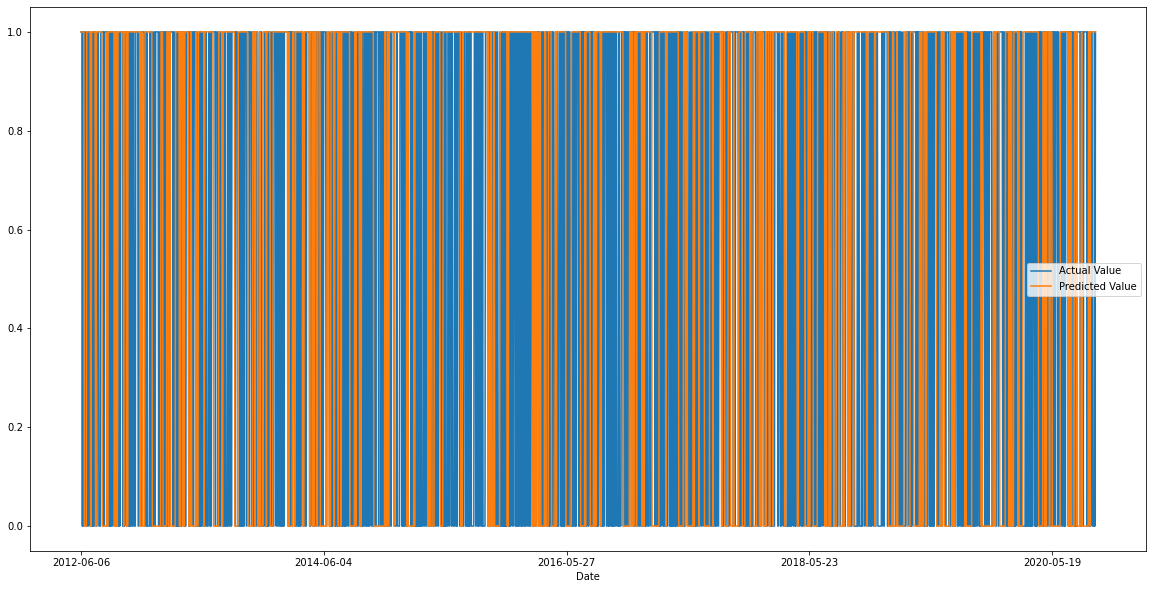

In [63]:
# Plot predicted results vs. actual results
results[['Actual Value', 'Predicted Value']].plot(figsize=(20,10))

## Plot Predicted Results vs. Actual Results (of last 20 records)

<AxesSubplot:xlabel='Date'>

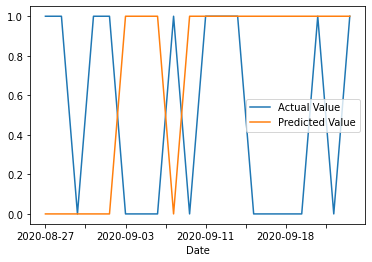

In [64]:
# Plot last 10 records of predicted vs. actual results
results[['Actual Value', 'Predicted Value']].tail(20).plot()

## Evaluate the model

In [65]:
# Function to print a confusion matrix
def cm_to_df(cm):
    print("Random Forest Classifier Confusion Matrix")
    cm_df = pd.DataFrame(cm, index=["Negative", "Positive"], columns=["Predicted Negative", "Predicted Positive"])
    return cm_df

# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_to_df(cm)


# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

#Get classification report
report =classification_report(y_test, predictions)

Random Forest Classifier Confusion Matrix


In [66]:
# Displaying results
display(cm_to_df(cm))
print()
print(f"Accuracy Score : {acc_score}")
print ()
print("Classification Report")
print(report)




Random Forest Classifier Confusion Matrix


,Predicted Negative,Predicted Positive
Negative,334,595
Positive,413,748



Accuracy Score : 0.5177033492822967

Classification Report
              precision    recall  f1-score   support

         0.0       0.45      0.36      0.40       929
         1.0       0.56      0.64      0.60      1161

    accuracy                           0.52      2090
   macro avg       0.50      0.50      0.50      2090
weighted avg       0.51      0.52      0.51      2090



## Replace Predicted Values 0 as -1 (For Shorting)

In [67]:
# Replace predicted values 0 to -1 to account for shorting
results['Predicted Value'].replace(0, -1, inplace=True)
results

,Return,Actual Value,Predicted Value
Date,,,
2012-06-06,0.022468,1.0,1.0
2012-06-07,0.000606,1.0,1.0
2012-06-08,0.007952,1.0,1.0
2012-06-11,-0.012697,0.0,1.0
2012-06-12,0.011491,1.0,1.0
...,...,...,...
2020-09-18,-0.015454,0.0,1.0
2020-09-21,-0.011130,0.0,1.0
2020-09-22,0.010184,1.0,1.0


## Plot Cumulative Returns of Random Forest Model

<AxesSubplot:xlabel='Date'>

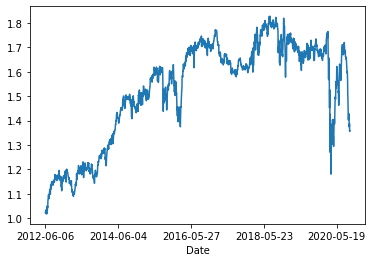

In [68]:
# Calculate cumulative return of model and plot the result
(1 + (results['Return'] * results['Predicted Value'])).cumprod().plot()

## Plot Cumulative Return of Random Forest Model (In Terms of Capital)

<AxesSubplot:xlabel='Date'>

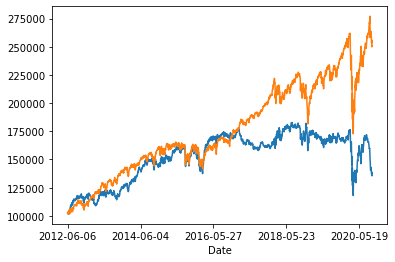

In [69]:
# Set initial capital allocation
initial_capital = 100000

# Plot cumulative return of model in terms of capital
cumulative_return_capital = initial_capital * (1 + (results['Return'] * results['Predicted Value'])).cumprod()
cumulative_return_capital.plot()

# Compare cumulative return of index (SP500)
cumulative_return_index=initial_capital * (1 + (results['Return'])) .cumprod()
cumulative_return_index.plot()